#### Import dataset

In [10]:
import pandas as pd
from typing import List

selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat', 'n1a', 'n2a', 'ff', 'egt', 'nf']

In [11]:
fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])

data = pd.concat([bgu, bdu]) \
  .drop(columns=['file_path', 'reason']) \
  .sort_values('reportts') \
  .reset_index() \
  .drop(columns=['index'])

# data = data[data['acnum'].isin(fleet)].dropna(subset=['egtm'])

#### Generate recursive features for n previous data points

In [41]:
def get_recursive_features(data: List[pd.DataFrame], features = [], n_back = 1):
  result = []
  for df in data:
    X = df[features]
    X_aug = X.copy()
    features_back = [i + "_1" for i in features]
    X_aug.loc[0, features_back] =  X.iloc[0,:].to_numpy()
    X_aug.loc[1:, features_back] = X.iloc[:-1,:].to_numpy()
    c = ['egtm', 'reportts', 'acnum', 'pos']
    X_aug.loc[:, c] = df[c]
    result.append(X_aug)
  
  result = pd.concat(result).sort_values('reportts') \
              .reset_index() \
              .drop(columns=['index'])
  return result

data = get_recursive_features([bgu, bdu], features=selected_params)

In [13]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_model(X, y, model = 'linreg'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  model = Ridge(alpha=0.2)

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  mse = mean_squared_error(y_train, predicted_train, squared=False)
  mae = mean_absolute_error(y_train, predicted_train)

  predicted_test = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted_test, squared=False)
  mae = mean_absolute_error(y_test, predicted_test)

  return mse, mae, model, predicted_train, predicted_test, train_i, y_test

In [14]:
X = data[selected_params]
y = data['egtm']

mse, mae, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
print(mse, mae)

4.0657345994745935 3.242534244822903


In [15]:
X = data.drop(columns=['egtm', 'acnum', 'pos', 'reportts'])
y = data['egtm']

mse, mae, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
print(mse, mae)

3.2300111474012403 2.580613467450849


In [32]:
# Get exponential rolling average with smothing factor alpha
def smooth(x: pd.Series, alpha=0.5):
  return pd.Series(x).ewm(alpha=alpha, adjust=False, ignore_na=True).mean().to_list()

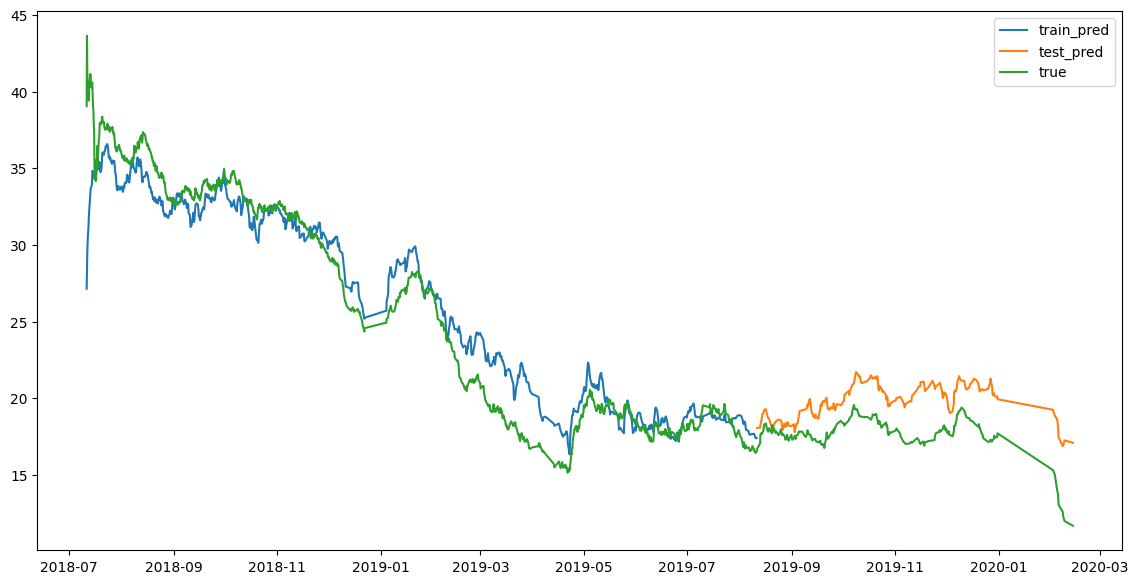

In [40]:
import matplotlib.pyplot as plt

def plot_smooth_predictions(data, acnum, pos, train_i, predicted_test, predicted_train):
  avg_test = ([None] * train_i) + smooth(predicted_test, alpha=1/10)
  avg_train = smooth(predicted_train, alpha=1/10) + ([None] * (len(data) - train_i)) 
  data.loc[:train_i-1, 'pred_train'] = predicted_train
  data.loc[train_i:, 'pred_test'] = predicted_test

  sub = data[(data['acnum'] == acnum) & (data['pos'] == pos)]

  plt.figure(figsize=(14, 7))

  train_i2 = sub['pred_train'].count()

  plt.plot(sub['reportts'][:train_i2], smooth(sub['pred_train'][:train_i2], alpha=1/10), '-')
  plt.plot(sub['reportts'], smooth(sub['pred_test'], alpha=1/10), '-')
  plt.plot(sub['reportts'], sub['egtm'], '-')

  plt.legend(['train_pred', 'test_pred', 'true'])
  plt.show()

plot_smooth_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train)

Note: I was using very wrong method for visualizing "smooth" data previously. no wonder plots looked weird and made no sense!